# How random numbers are generated on a computer

A pseudorandom number generator (PRNG), also known as a deterministic random bit generator (DRBG),is an algorithm for generating a sequence of numbers whose properties approximate the properties of sequences of random numbers. The PRNG-generated sequence is not truly random, because it is completely determined by an initial value, called the PRNG's seed (which may include truly random values). Although sequences that are closer to truly random can be generated using hardware random number generators, pseudorandom number generators are important in practice for their speed in number generation and their reproducibility.PRNGs are central in applications such as simulations (e.g. for the Monte Carlo method), electronic games (e.g. for procedural generation), and cryptography. Cryptographic applications require the output not to be predictable from earlier outputs, and more elaborate algorithms, which do not inherit the linearity of simpler PRNGs, are needed.Good statistical properties are a central requirement for the output of a PRNG. In general, careful mathematical analysis is required to have any confidence that a PRNG generates numbers that are sufficiently close to random to suit the intended use. John von Neumann cautioned about the misinterpretation of a PRNG as a truly random generator, joking that "Anyone who considers arithmetical methods of producing random digits is, of course, in a state of sin."See also "https://en.wikipedia.org/wiki/Procedural_generation"

# 1 . Gen WGN

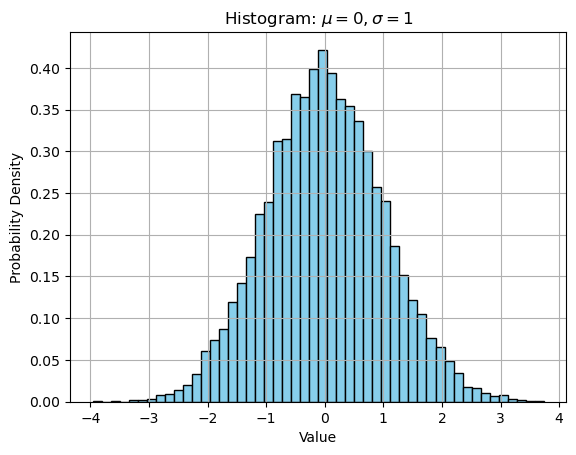

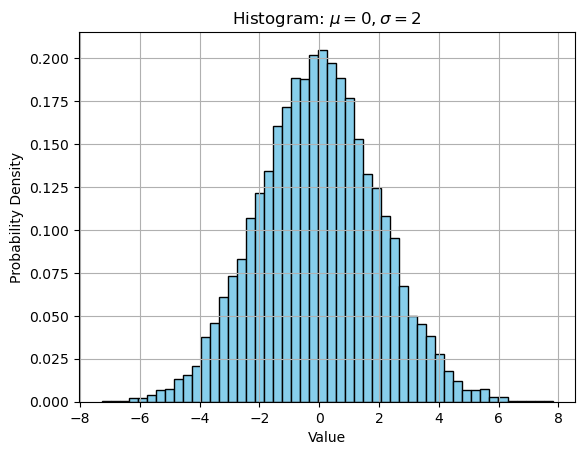

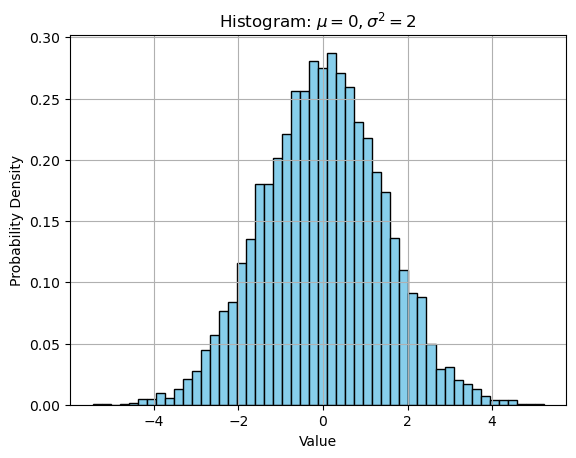

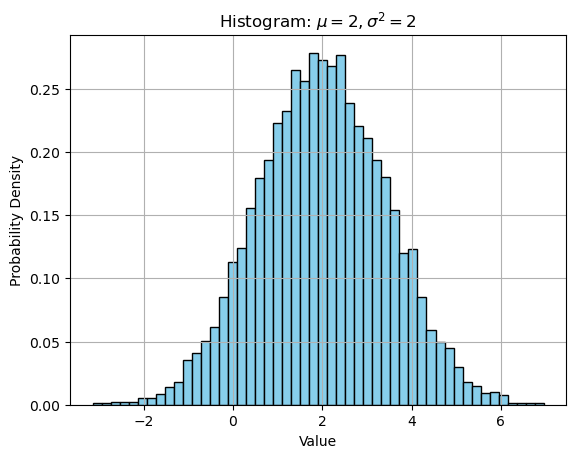

$\mu = 0, \sigma = 1$: mean = 0.0049, std = 1.0038

$\mu = 0, \sigma = 2$: mean = -0.0201, std = 2.0001

$\mu = 0, \sigma^2 = 2$: mean = 0.0071, std = 1.4152

$\mu = 2, \sigma^2 = 2$: mean = 2.0078, std = 1.4296

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Sample numbers
nSampls = 10000

#Params
x1 = np.random.normal(loc = 0, scale = 1, size = nSampls)               # μ=0, σ=1
x2 = np.random.normal(loc = 0, scale = 2, size = nSampls)               # μ=0, σ=2
x3 = np.random.normal(loc = 0, scale = np.sqrt(2), size = nSampls)      # μ=0, σ²=2
x4 = np.random.normal(loc = 2, scale = np.sqrt(2), size = nSampls)      # μ=2, σ²=2

# Add to list
samples = [x1, x2, x3, x4]
titles = [
    r'$\mu = 0, \sigma = 1$',
    r'$\mu = 0, \sigma = 2$',
    r'$\mu = 0, \sigma^2 = 2$',
    r'$\mu = 2, \sigma^2 = 2$'
]

# Plot 
for i in range(4):
    plt.figure()
    plt.hist(samples[i], bins=50, density=True, color='skyblue', edgecolor='black')
    plt.title(f'Histogram: {titles[i]}')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.show()

# Mean and Std
for i, x in enumerate(samples):
    mu = np.mean(x)
    sigma = np.std(x)
    display(Markdown(f'{titles[i]}: mean = {mu:.4f}, std = {sigma:.4f}'))

## Challenge exercise

Theoretical covariance matrix C：
 [[2.  0.5 0.3]
 [0.5 1.5 0.4]
 [0.3 0.4 1. ]]

Sample covariance matrix：
 [[2.01781112 0.51999866 0.30781249]
 [0.51999866 1.51822243 0.41577937]
 [0.30781249 0.41577937 1.00508696]]


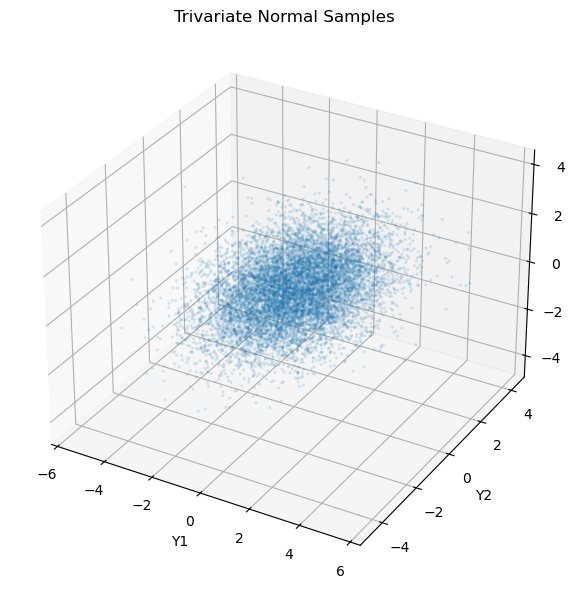

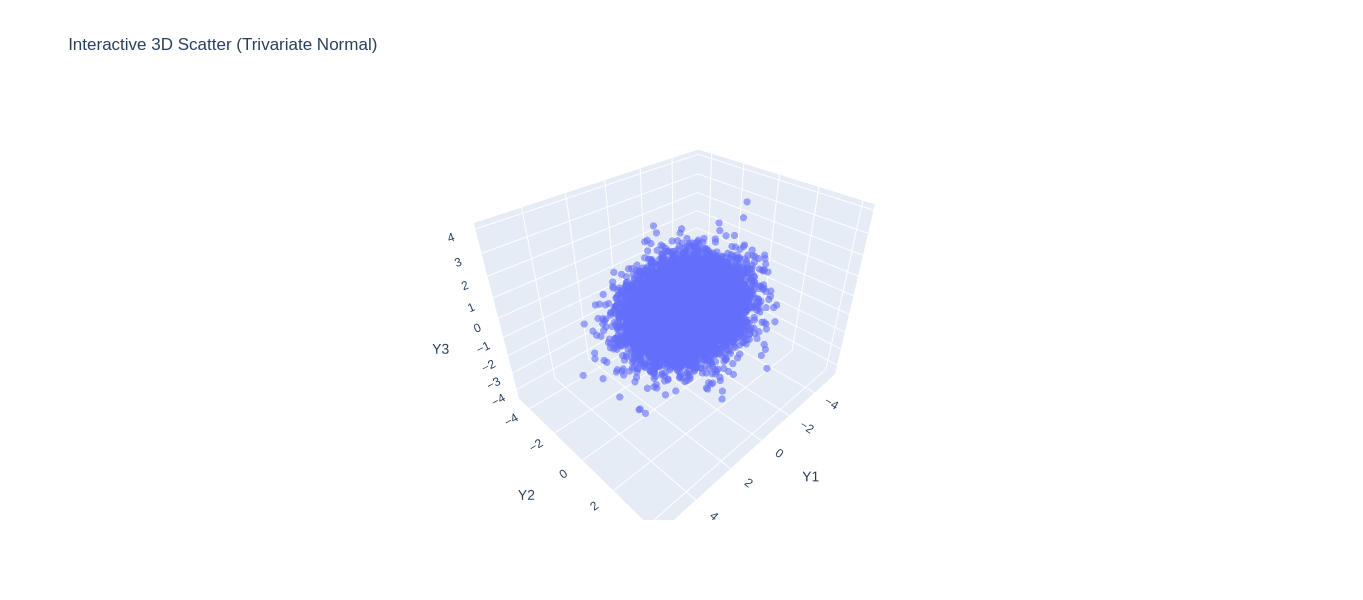

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider

# Generate a covariance matrix C（symmetric and positive definite）
C = np.array([[2.0, 0.5, 0.3],
              [0.5, 1.5, 0.4],
              [0.3, 0.4, 1.0]])  # Cij=Cov(Xi,Xj)=E[(Xi−μi)(Xj−μj)]

# C = A @ A.T
A = np.linalg.cholesky(C)

# Generate three independent varables X ~ N(0, I)
n_samples = 10000
X = np.random.randn(3, n_samples)  # shape (3, N)

# Linear transform Y = A X ⇒ Y ~ N(0, C)
Y0 = A @ X
Y = Y0.T

# Vertify covariance
print("Theoretical covariance matrix C：\n", C)
print("\nSample covariance matrix：\n", np.cov(Y.T))    #Each row is considered a trial value

# Plot 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], s=2, alpha=0.1)
ax.set_xlabel('Y1')
ax.set_ylabel('Y2')
ax.set_zlabel('Y3')
plt.title("Trivariate Normal Samples")
plt.tight_layout()
plt.show()

# 3D interactive
fig = go.Figure(data=[go.Scatter3d(
    x=Y0[0], y=Y0[1], z=Y0[2],
    mode='markers',
    marker=dict(size=2, opacity=0.6)
)])

fig.update_layout(scene=dict(
    xaxis_title='Y1',
    yaxis_title='Y2',
    zaxis_title='Y3'),
    title='Interactive 3D Scatter (Trivariate Normal)',
    width=600,
    height=600              
)
fig.show()

# 2 . Coloring and whitening

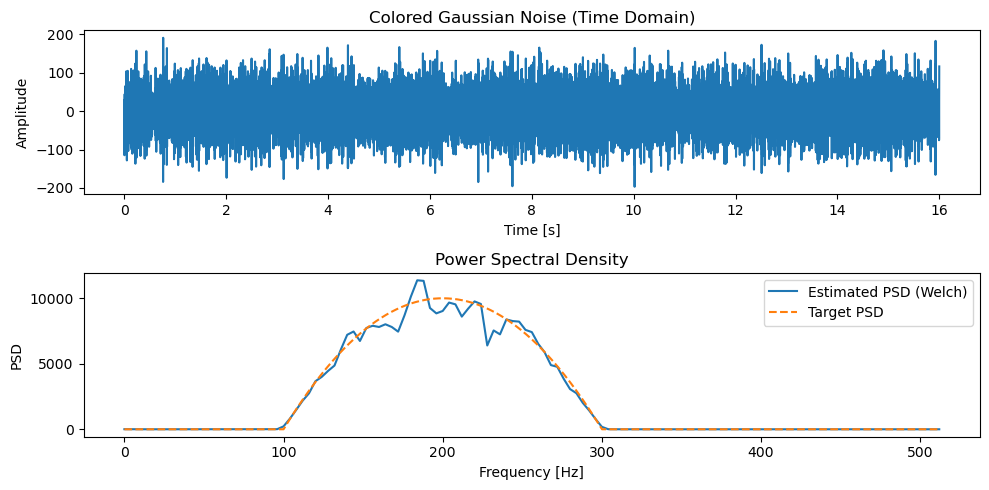

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Params
fs = 1024  
nSample = 16384  
t = np.arange(nSample) / fs

# Generate white noise
white_noise = np.random.randn(nSample)   # Generate standard norm distribution

# Construct PSD S_out(f)
f = np.fft.rfftfreq(nSample, d=1/fs)  #Only positive
S_out = np.zeros_like(f)
mask = (f >= 100) & (f <= 300)
S_out[mask] = (f[mask] - 100) * (300 - f[mask])

# Construct transit function T(f) = sqrt(S_out(f))
T_f = np.sqrt(S_out)

# Apply filter T(f) to white noise to generate colored noise
W_f = np.fft.rfft(white_noise)
Y_f = W_f * T_f
colored_noise = np.fft.irfft(Y_f, nSample)  #Inverse

# Vertify PSD (Welch method)
f_welch, Pxx = welch(colored_noise, fs = fs, nperseg = 256)
Pxx = Pxx * 0.5e+03    # Rescale

# Plot
plt.figure(figsize = (10, 5))

plt.subplot(2, 1, 1)
plt.plot(t, colored_noise)
plt.title("Colored Gaussian Noise (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(f_welch, Pxx, label="Estimated PSD (Welch)")
plt.plot(f, S_out, label="Target PSD", linestyle='--')
plt.title("Power Spectral Density")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")
plt.legend()
plt.tight_layout()
plt.show()

# Additional

## Time serise of noise

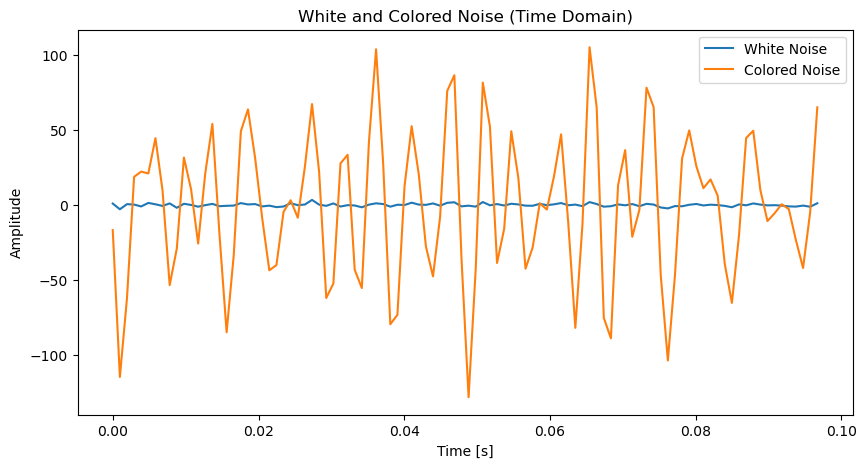

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(t[:100], white_noise[:100], label="White Noise")
plt.plot(t[:100], colored_noise[:100], label="Colored Noise")
plt.title("White and Colored Noise (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

## Histogram of noise

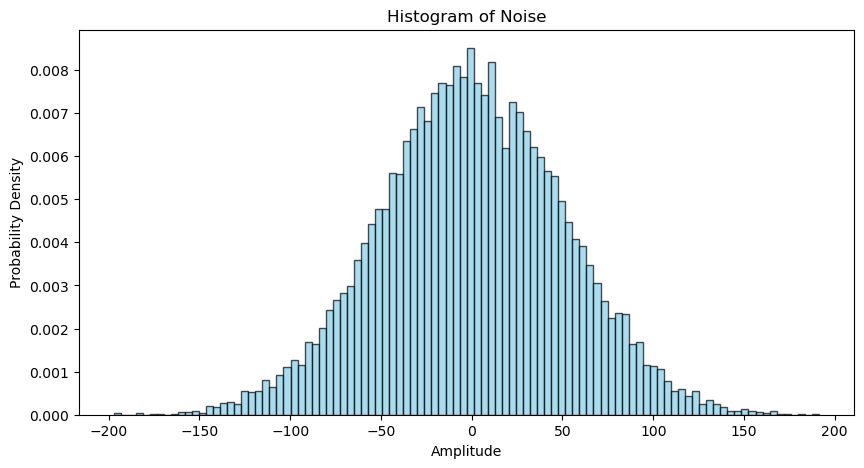

In [5]:
plt.figure(figsize=(10,5))
plt.hist(colored_noise, bins=100, density=True, alpha=0.7, label='Colored Noise',color='skyblue', edgecolor='black')
# plt.hist(white_noise, bins=100, density=True, alpha=0.5, label='White Noise', edgecolor='black')
plt.title("Histogram of Noise")
plt.xlabel("Amplitude")
plt.ylabel("Probability Density")
plt.show()   # Still a norm

## Vertify the influence of sample numbers

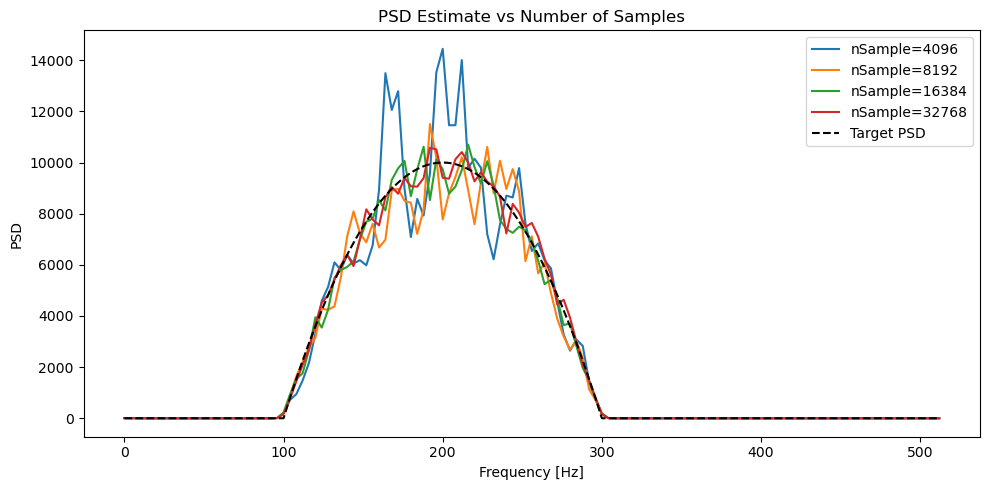

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

fs = 1024
nperseg = 256

sample_list = [4096, 8192, 16384, 32768]  # Increse the sample numbers
plt.figure(figsize=(10, 5))

for nSample in sample_list:
    t = np.arange(nSample) / fs
    white_noise = np.random.randn(nSample)
    f = np.fft.rfftfreq(nSample, d=1/fs)
    S_out = np.zeros_like(f)
    mask = (f >= 100) & (f <= 300)
    S_out[mask] = (f[mask] - 100) * (300 - f[mask])
    T_f = np.sqrt(S_out)
    W_f = np.fft.rfft(white_noise)
    Y_f = W_f * T_f
    colored_noise = np.fft.irfft(Y_f, nSample)
    f_welch, Pxx = welch(colored_noise, fs=fs, nperseg=nperseg)
    Pxx = Pxx * 0.5e+03  
    plt.plot(f_welch, Pxx, label=f'nSample={nSample}')

plt.plot(f, S_out, '--', color='k', label='Target PSD')
plt.title("PSD Estimate vs Number of Samples")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")
plt.legend()
plt.tight_layout()
plt.show()

# Tasks

Sampling frequency =  1024.0


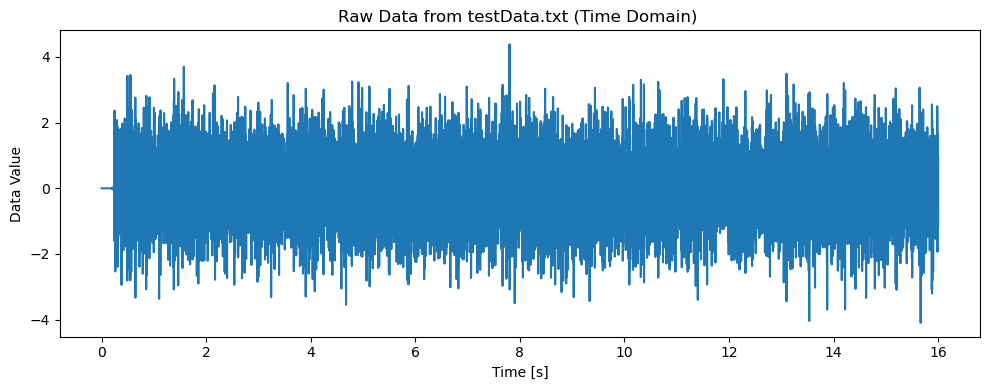

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('testData.txt')
t = data[:, 0]     # Time 
signal = data[:, 1]  # Signal data

# Calculate sample rates 
fs = 1 / (t[1] - t[0])
print('Sampling frequency = ', fs)

# Show the time domain waveform
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.xlabel("Time [s]")
plt.ylabel("Data Value")
plt.title("Raw Data from testData.txt (Time Domain) ")
plt.tight_layout()
plt.show()

In [8]:
# Select the noise part

noise_mask = t < 4.99
noise_part = signal[noise_mask]

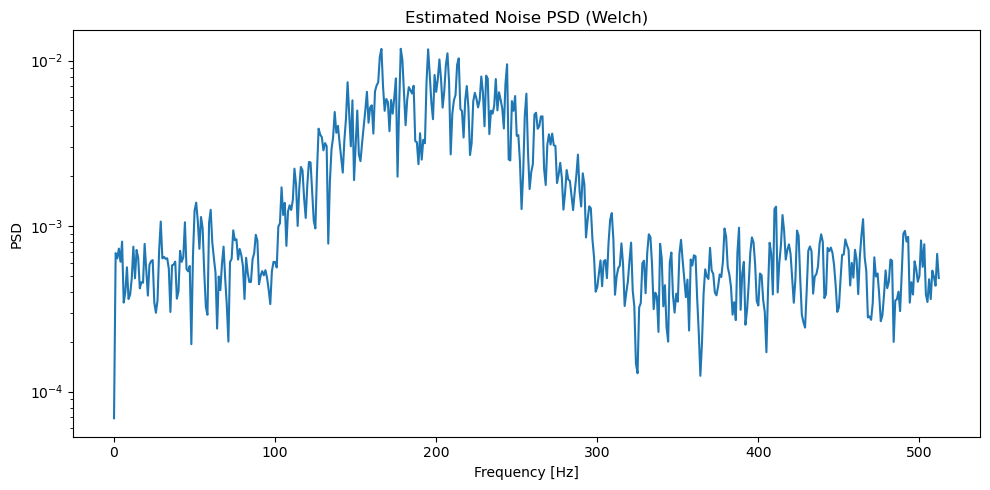

In [9]:
from scipy.signal import welch

# Estimate noise PSD
f, Pxx = welch(noise_part, fs=fs, nperseg=1024)
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Estimated Noise PSD (Welch)')
plt.tight_layout()
plt.show()

## Follow the statgaussnoisegen.m

In [10]:
from scipy.signal import firwin2, lfilter

# Normalize frequencies to [0, 1]（firwin2 required）
freq_norm = f / (fs / 2)
H_white = 1.0 / np.sqrt(Pxx)   # Whitening filter response in the frequency domain
H_white[-1] = 0  # the last point should be 0

# Design of FIR whitening filter
order = 512
b = firwin2(order, freq_norm, H_white)

In [11]:
# Perform time domain filtering on the original signal
signal_white = lfilter(b, 1.0, signal)

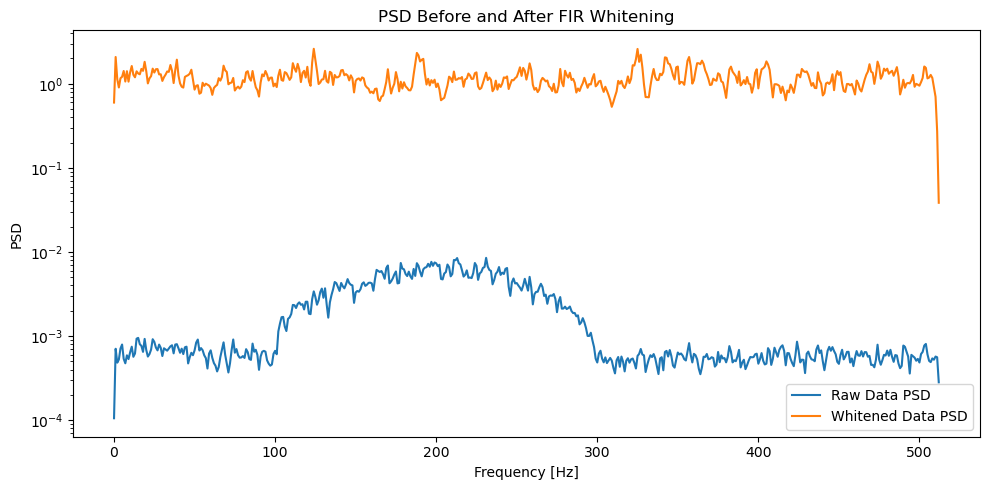

In [12]:
# Using welch method and plot the PSD
from scipy.signal import welch

f_raw, Pxx_raw = welch(signal, fs=fs, nperseg=1024)
f_white, Pxx_white = welch(signal_white, fs=fs, nperseg=1024)

plt.figure(figsize=(10,5))
plt.semilogy(f_raw, Pxx_raw, label='Raw Data PSD')
plt.semilogy(f_white, Pxx_white, label='Whitened Data PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('PSD Before and After FIR Whitening')
plt.legend()
plt.tight_layout()
plt.show()

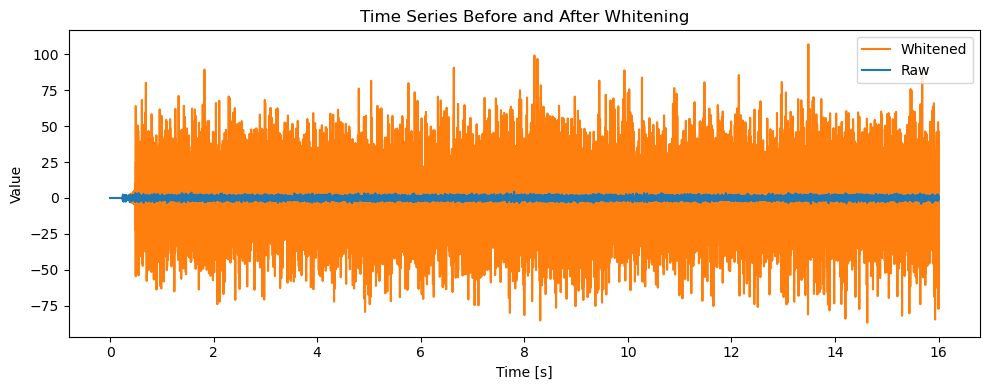

In [13]:
plt.figure(figsize=(10,4))
plt.plot(t, signal_white, label='Whitened', color='#ff7f0e')
plt.plot(t, signal, label='Raw', color='#1f77b4')
plt.xlabel("Time [s]")
plt.ylabel("Value")
plt.title("Time Series Before and After Whitening")
plt.legend()
plt.tight_layout()
plt.show()

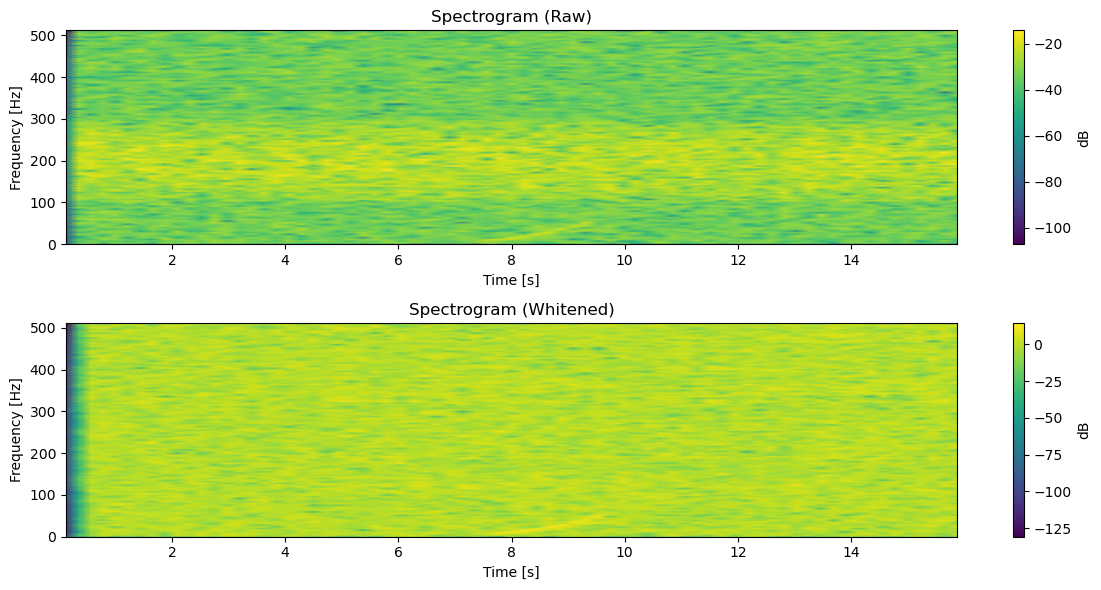

In [14]:
from scipy.signal import spectrogram

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
f_s, t_s, Sxx = spectrogram(signal, fs=fs)
plt.pcolormesh(t_s, f_s, 10*np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram (Raw)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='dB')

plt.subplot(2,1,2)
f_s, t_s, Sxx = spectrogram(signal_white, fs=fs)
plt.pcolormesh(t_s, f_s, 10*np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram (Whitened)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

## * Another classical process

In [15]:
from scipy.interpolate import interp1d

# Perform rfft
f_full = np.fft.rfftfreq(len(signal), d=1/fs)  # d=Sample interval

# Interpolation Pxx
Pxx_interp = interp1d(f, Pxx, bounds_error=False, fill_value="extrapolate")
whitening_filter = 1.0 / np.sqrt(Pxx_interp(f_full))

# Whitening in frequency domain
S_full = np.fft.rfft(signal)
S_white = S_full * whitening_filter
signal_white = np.fft.irfft(S_white, len(signal))

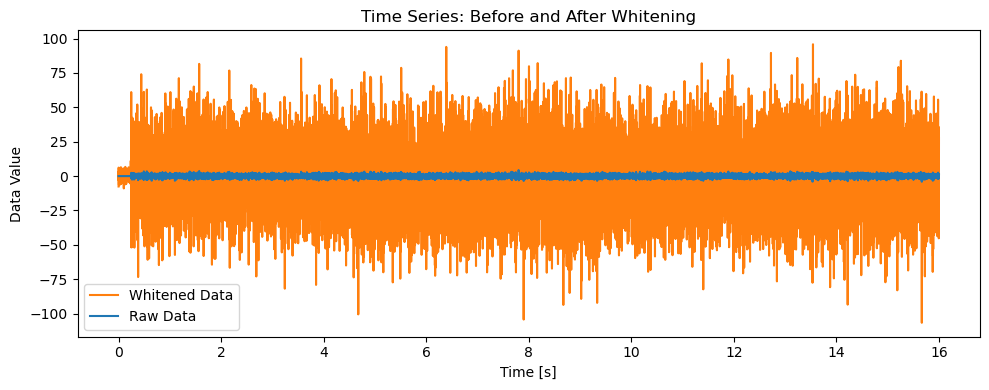

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(t, signal_white, label='Whitened Data', color='#ff7f0e')
plt.plot(t, signal, label='Raw Data', color='#1f77b4')
plt.xlabel("Time [s]")
plt.ylabel("Data Value")
plt.title("Time Series: Before and After Whitening")
plt.legend()
plt.tight_layout()
plt.show()

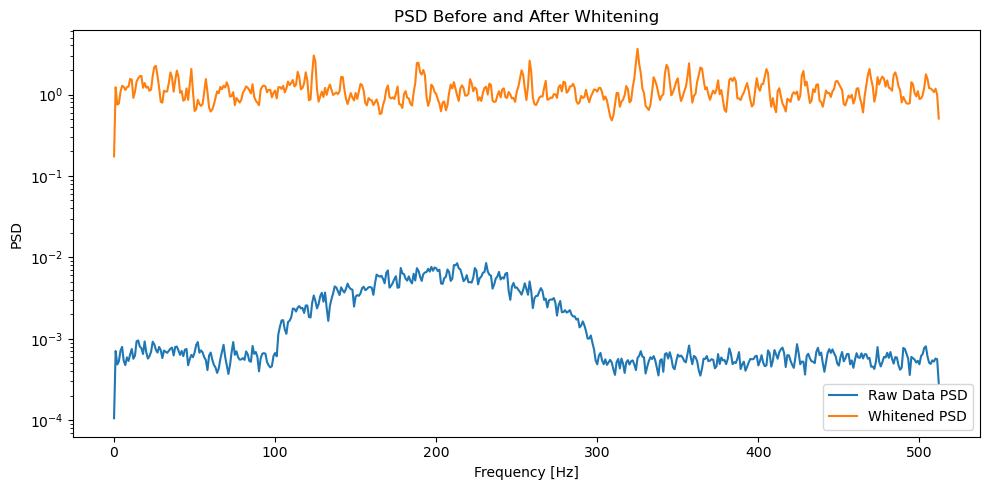

In [17]:
f_orig, Pxx_orig = welch(signal, fs=fs, nperseg=1024)
f_white, Pxx_white = welch(signal_white, fs=fs, nperseg=1024)

plt.figure(figsize=(10,5))
plt.semilogy(f_orig, Pxx_orig, label='Raw Data PSD')
plt.semilogy(f_white, Pxx_white, label='Whitened PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('PSD Before and After Whitening')
plt.legend()
plt.tight_layout()
plt.show()

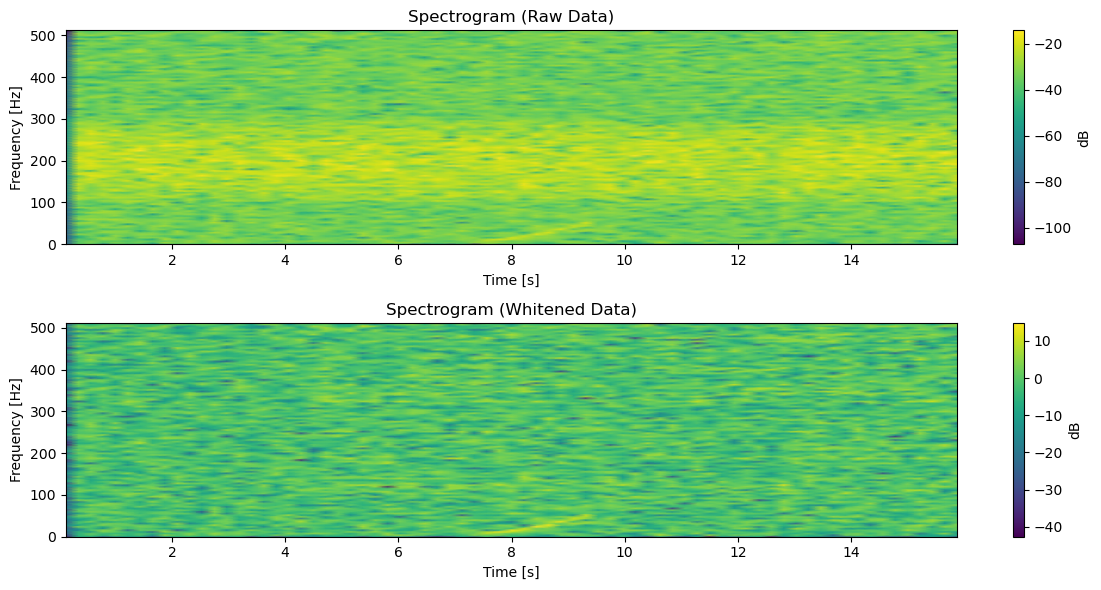

In [18]:
from scipy.signal import spectrogram

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
f_s, t_s, Sxx = spectrogram(signal, fs=fs)
plt.pcolormesh(t_s, f_s, 10*np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram (Raw Data)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='dB')

plt.subplot(2,1,2)
f_s, t_s, Sxx = spectrogram(signal_white, fs=fs)
plt.pcolormesh(t_s, f_s, 10*np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram (Whitened Data)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()
# As you can see, the signal is not necessarily clearer!

# 3 . Simulating LIGO noise

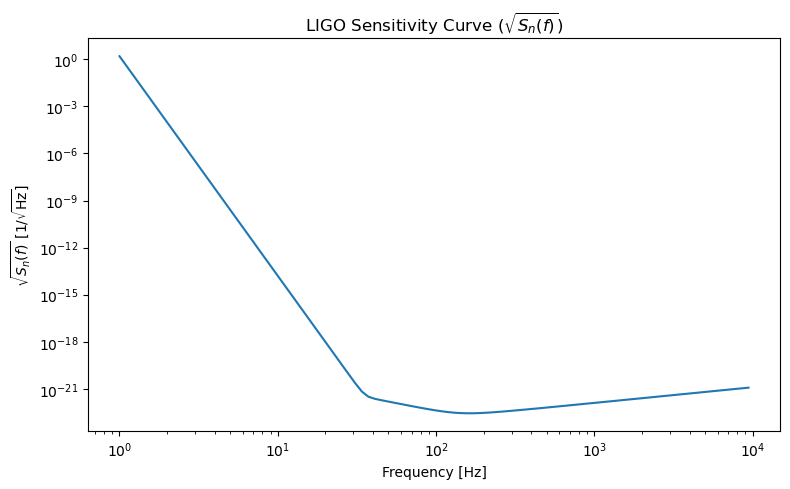

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Load data
data = np.loadtxt('iLIGOSensitivity.txt')
freq = data[:, 0]
sqrt_PSD = data[:, 1]

plt.figure(figsize=(8, 5))
plt.loglog(freq, sqrt_PSD)  # use log-log coordinate for intuitive
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\sqrt{S_n(f)}$ [1/$\sqrt{\mathrm{Hz}}$]')
plt.title(r'LIGO Sensitivity Curve ($\sqrt{S_n(f)}$)')
#plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

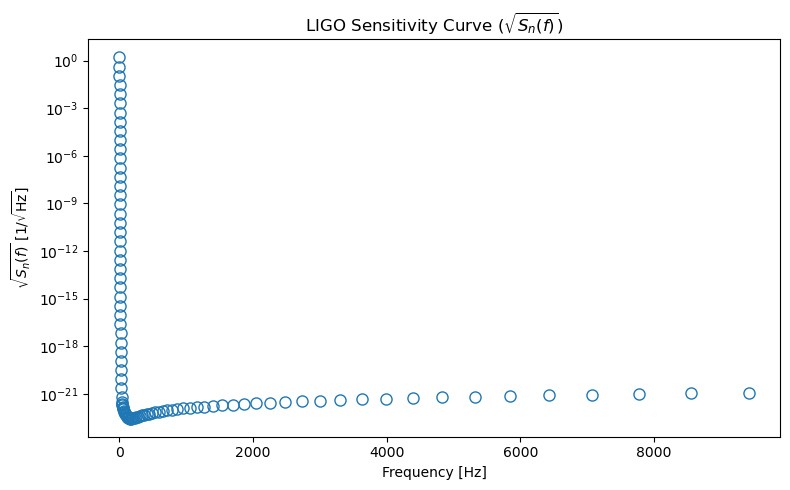

In [20]:
plt.figure(figsize=(8, 5))
plt.semilogy(freq, sqrt_PSD, 'o', markersize=8, markerfacecolor='none', markeredgecolor='#1f77b4')  # use log-log coordinate for intuitive
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\sqrt{S_n(f)}$ [1/$\sqrt{\mathrm{Hz}}$]')
plt.title(r'LIGO Sensitivity Curve ($\sqrt{S_n(f)}$)')
#plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

## Task

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin2, lfilter, welch

# Load data
data = np.loadtxt('iLIGOSensitivity.txt')
freq = data[:, 0]  
sqrt_PSD = data[:, 1]  
PSD = sqrt_PSD**2      

In [22]:
# Flat processing
def closest_idx(arr, val):
    return np.argmin(np.abs(arr - val))

idx_50 = closest_idx(freq, 50)
idx_700 = closest_idx(freq, 700)

PSD_proc = PSD.copy()
PSD_proc[freq < 50] = PSD[idx_50]
PSD_proc[freq > 700] = PSD[idx_700]

In [23]:
fs = 2048      # Sampling frequency
nyquist = fs / 2

In [24]:
# Only keep the part <= nyquist
mask = freq <= nyquist
freq_cut = freq[mask]
PSD_cut = PSD_proc[mask]

# Complement endpoint
if freq_cut[0] > 0:
    freq_cut = np.insert(freq_cut, 0, 0.0)
    PSD_cut = np.insert(PSD_cut, 0, PSD_cut[0])

if freq_cut[-1] < nyquist:
    freq_cut = np.append(freq_cut, nyquist)
    PSD_cut = np.append(PSD_cut, PSD_cut[-1])

In [25]:
order = 2049
freq_norm = freq_cut / nyquist
filter_gain = np.sqrt(PSD_cut)
# filter_gain[-1] = 0  # if order is a even number
b = firwin2(order, freq_norm, filter_gain)

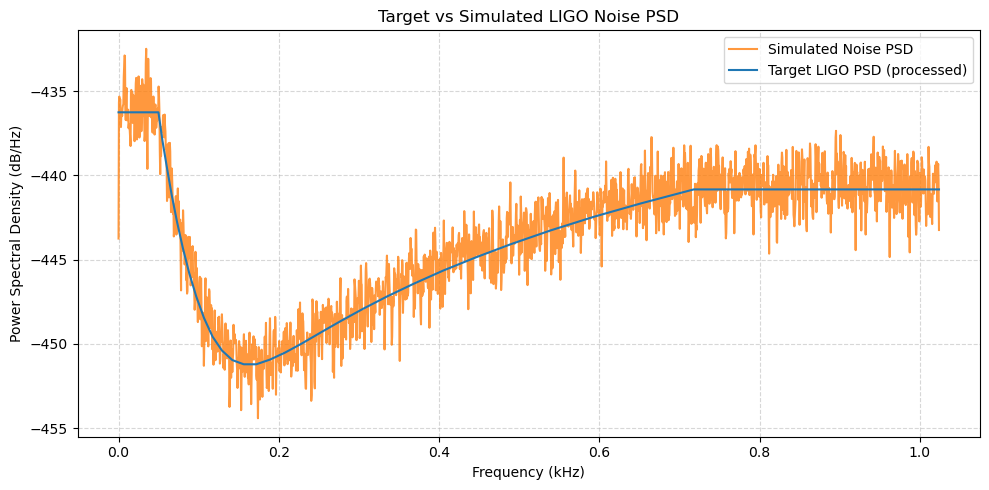

In [26]:
nSample = fs * 16  # Sampling 16 seconds of data
white_noise = np.random.randn(nSample)
sim_noise = lfilter(b, 1.0, white_noise)

# Verify PSD
f_sim, Pxx_sim = welch(sim_noise, fs=fs, nperseg=4096)

# Select a comparison frequency band, such as 100~200Hz
mask = (f_sim > 100) & (f_sim < 200)
target_interp = np.interp(f_sim[mask], freq_cut, PSD_cut)
scale_factor = np.sqrt(np.mean(target_interp / Pxx_sim[mask]))

sim_noise_scaled = sim_noise * scale_factor
f_sim, Pxx_sim = welch(sim_noise_scaled, fs=fs, nperseg=4096)

# Plot
plt.figure(figsize=(10,5))
plt.plot(f_sim / 1000, 10 * np.log10(Pxx_sim), label='Simulated Noise PSD', alpha=0.8, color='#ff7f0e')
plt.plot(freq_cut / 1000, 10 * np.log10(PSD_cut), label='Target LIGO PSD (processed)', color='#1f77b4')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.legend()
plt.title('Target vs Simulated LIGO Noise PSD')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()
